# LA Metro Bikeshare EDA
1. Story planning
2. Obtain data sets - D
3. Obtain lat longs with scraper
4. Clean data sets 
5. Feature engineering
6. Visualization
7. TBD

Is there a predictive value that can be derived for kinds of locations
    1. Finding lat long coordinates of schools or public services and mapping out color coded heat maps based on the type of establishment
    2. Finding out where most bike stations are likely to be located
    3. Goal is to find out where you would set up more bike locations + figure out why particular locations are popular and predict accordingly

In [65]:
# importing necessary packages
import pandas as pd
import pprint
import missingno as msno
import urllib.request
import json

# Core rides dataset

In [37]:
# there are 4 files for the data for each quarter from 2017 Q3 to 2018 Q2
_2017Q3 = pd.read_csv('../data/external/2017Q3.csv')
_2017Q4 = pd.read_csv('../data/external/2017Q4.csv')
_2018Q1 = pd.read_csv('../data/external/2018Q1.csv')
_2018Q2 = pd.read_csv('../data/external/2018Q2.csv')

In [38]:
# concatenate the four quarters of ride sharing data into a year's worth
rides_df = pd.concat([_2017Q3,_2017Q4,_2018Q1,_2018Q2])
rides_df.shape

(286295, 14)

In [39]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,33404951,36,7/1/2017 0:09,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up
1,33404950,13,7/1/2017 0:10,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up
2,33404947,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up
3,33404948,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up
4,33404949,12,7/1/2017 0:11,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up


In [40]:
rides_df.describe()

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration
count,2.862950e+05,286295.000000,286295.00000,285660.000000,285660.000000,286295.000000,281900.000000,281900.000000,286295.000000,286295.000000
mean,6.480957e+07,35.034206,3420.79971,34.045820,-118.271421,3414.716265,34.045689,-118.271667,7900.573014,30.907910
std,1.808223e+07,115.722913,538.47854,0.065529,0.097562,537.212309,0.065038,0.098157,2717.473129,66.243336
min,3.340494e+07,1.000000,3000.00000,33.710979,-118.491341,3000.000000,33.710979,-118.491341,4727.000000,0.000000
25%,4.905606e+07,7.000000,3031.00000,34.039982,-118.262733,3031.000000,34.039982,-118.262733,6053.000000,0.000000
50%,6.534754e+07,12.000000,3064.00000,34.046822,-118.252441,3063.000000,34.046810,-118.252830,6403.000000,30.000000
75%,8.085881e+07,25.000000,4156.00000,34.053200,-118.237411,4156.000000,34.051941,-118.237410,12019.000000,30.000000
max,9.508575e+07,1440.000000,4254.00000,34.165291,-118.116530,4254.000000,34.165291,-118.116530,12456.000000,365.000000


In [41]:
rides_df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

On first glance, all time variables like start_time and end_time should be converted to a date time object.

In [51]:
# converting start and end times to datetime objects
rides_df['start_time'] = pd.to_datetime(rides_df['start_time'])
rides_df['end_time'] = pd.to_datetime(rides_df['end_time'])

In [52]:
# checking to see if columns were indeed converted
rides_df.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                         int64
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object

In [54]:
# quick look at which station is the most commonly used and where it is (Venice beach)
rides_df['start_station'].mode()

0    4214
dtype: int64

In [53]:
rides_df[rides_df['start_station'] == 4214].head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
51390,44620579,16,2017-09-07 10:40:00,2017-09-07 10:56:00,4214,33.99556,-118.481552,4216,34.023392,-118.479637,11200,30,One Way,Monthly Pass
51391,44627346,28,2017-09-07 10:40:00,2017-09-07 11:08:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12416,365,One Way,Flex Pass
51393,44641142,167,2017-09-07 10:40:00,2017-09-07 13:27:00,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12241,365,One Way,Flex Pass
51394,44620577,17,2017-09-07 10:41:00,2017-09-07 10:58:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12356,30,One Way,Monthly Pass
51395,44627343,28,2017-09-07 10:41:00,2017-09-07 11:09:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12431,30,One Way,Monthly Pass


Here we use the missingno package to check for NA values in the dataframe. As the number of missing values seem almost negligible compared to the total number of observations, we drop the rows. Around 4849 rows, or 1.7% of total rows were dropped.

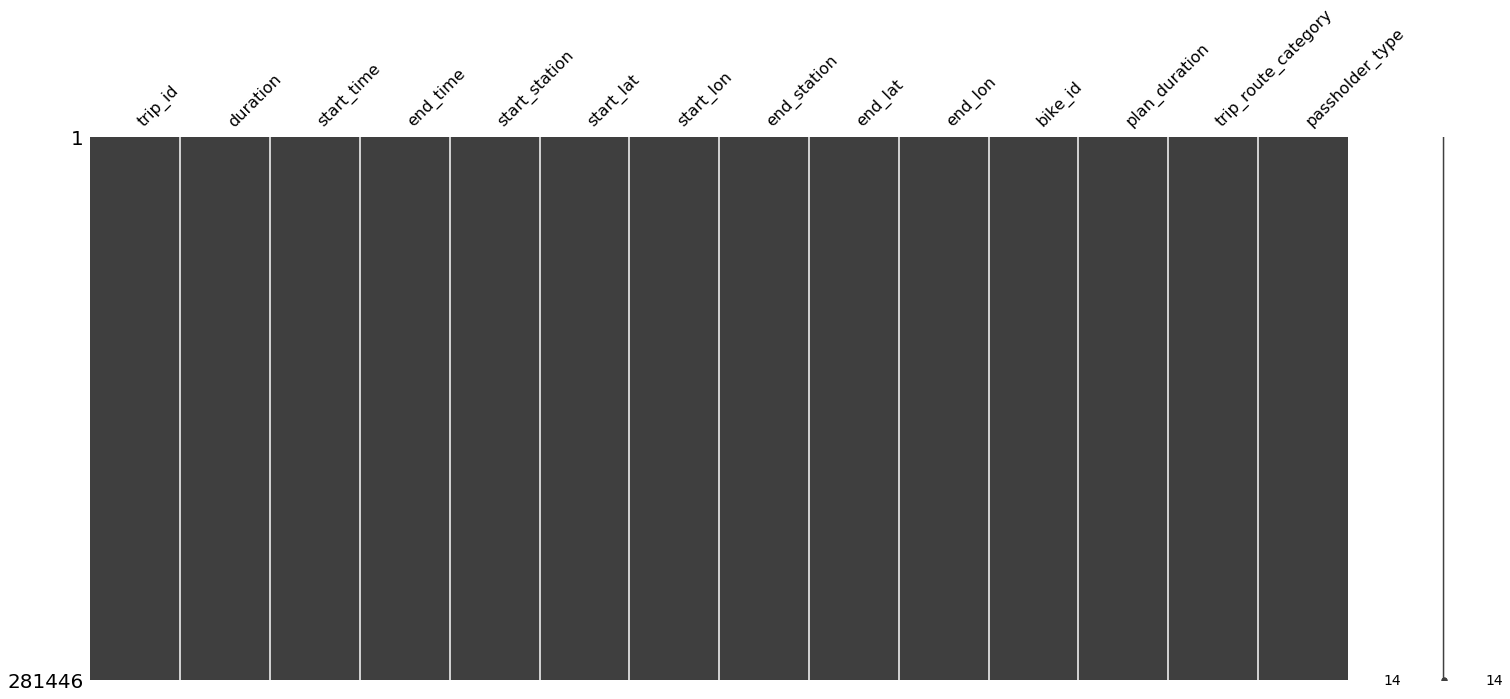

In [55]:
# check for missing values
%matplotlib inline
msno.matrix(rides_df)

In [47]:
# dropping rows with na values
rides_df = rides_df.dropna()
rides_df.shape

(281446, 14)

# External datasets of geolocations

In order to obtain a perspective of where most rides occur and landmarks around LA, we utilize multiple data sources and APIs to obtain the relevant latitude and longitude values.

### Bike station locations
We first start off with more detailed information on the bike stations. To do this, we download the json file from https://bikeshare.metro.net/stations/json/ which includes addresses and capacities of different bike stations.

In [139]:
# read in the json file with station information
with open ('../data/external/bike_stations.json') as f:
    station_data = json.load(f)

In [140]:
# extract useful columns from the jason and append it to a list
all_station_info = []
for station in station_data['features']: 
    station_attr = []
    station_attr.append([station['properties']['kioskId'], station['properties']['addressStreet'], 
                         station['properties']['addressZipCode'], station['properties']['name'],
                         station['properties']['totalDocks']])
    all_station_info.append(station_attr[0])

In [141]:
# check to see if each element in list is a list of station attributes we need
all_station_info[2]

[3007, '557 S 5th Street', '90071', '5th & Grand', 23]

In [142]:
# create new dataframe based on the attributes
stations_info = pd.DataFrame(all_station_info, columns=['kiosk_id','address_street','address_zip','station_name','total_docks'])
stations_info.head()

,kiosk_id,address_street,address_zip,station_name,total_docks
0,3005,723 Flower Street,90017,7th & Flower,27
1,3006,729 S Olive Street,90014,Olive & 8th,24
2,3007,557 S 5th Street,90071,5th & Grand,23
3,3008,865 S Figueroa Street,90017,Figueroa & 9th,15
4,3010,401 East 11th Street,90015,11th & Maple,22


In [163]:
# adding start station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'start_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'start_address',
                                                          'address_zip':'start_zip','station_name':'start_name',
                                                          'total_docks':'start_docks'}).drop('kiosk_id',1)
# adding end station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'end_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'end_address',
                                                          'address_zip':'end_zip','station_name':'end_name',
                                                          'total_docks':'end_docks'}).drop('kiosk_id',1)

In [168]:
df1.head(10)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0
5,33404946,18,2017-07-01 00:12:00,2017-07-01 00:30:00,3047,34.039982,-118.266403,3005,34.048500,-118.258537,5778,0,One Way,Walk-up,515 W Pico Street,90015,Pico & Flower,36.0
6,33404945,23,2017-07-01 00:20:00,2017-07-01 00:43:00,3067,34.045181,-118.250237,3055,34.044159,-118.251579,5901,30,One Way,Monthly Pass,640 S Spring Street,90014,Main & 6th,19.0
7,33404944,3,2017-07-01 00:24:00,2017-07-01 00:27:00,3005,34.048500,-118.258537,3051,34.045422,-118.253517,5905,30,One Way,Monthly Pass,723 Flower Street,90017,7th & Flower,27.0
8,33404943,4,2017-07-01 00:32:00,2017-07-01 00:36:00,3046,34.053020,-118.247948,3062,34.047749,-118.243172,6254,30,One Way,Monthly Pass,201 South Hill Street,90021,2nd & Hill,17.0
9,33404942,8,2017-07-01 00:33:00,2017-07-01 00:41:00,3038,34.046822,-118.248352,3038,34.046822,-118.248352,6176,30,Round Trip,Monthly Pass,458 S Main Street,90013,Main & 5th,18.0


### 

In [209]:
PARAMS = {"limit":2000}
r = requests.get('https://data.lacity.org/resource/9nfs-4e72.json', params=PARAMS)

In [214]:
businesses = r.json()
businesses

{'error': True, 'message': 'Unrecognized arguments [limit]'}

In [211]:
las = []
for x in businesses:
    if x['city'] == 'LOS ANGELES':
        las.append(x['business_name'])

TypeError: string indices must be integers

In [213]:
len(businesses)

2